In [1]:
# For each stay, this file finds an appropriate building-match
# within the tract.

In [2]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist
import scipy.spatial.distance as ssd
from six.moves import cPickle as pickle
import os
from collections import Counter as counter
import random
from matplotlib.patches import Polygon as Polygon2
from matplotlib.collections import PatchCollection
import matplotlib.path as mplPath
%matplotlib inline
# Clustering code source:
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [3]:
# Total Stays = 2103774
# Consecutive stays in same tract = 147
LONG_TO_FEET = 82850.73*3.28
LONG_TO_METERS = 82850.73
LAT_TO_FEET = 111073.25*3.28
LAT_TO_METERS = 111073.25
tracts = os.listdir('../PickledData/HyperlocalBuildings/')
tracts = [x.split('.')[0] for x in tracts if '.pickle' in x]

In [4]:
tractBuildings = {}
for t in tracts:
    with open('../PickledData/HyperlocalBuildings/'+t+'.pickle', 'rb') as f:
        tractBuildings[t] = pickle.load(f)
        
tractStays = {}
for t in tracts:
    with open('../PickledData/TractStays/'+t+'.pickle', 'rb') as f:
        tractStays[t] = pickle.load(f)
        tractStays[t].sort(key=lambda x:x['startSlot'])

In [5]:
print tractStays[t][0]

{'endSlot': 168, 'userId': '2147434', 'longitude': -71.07622, 'latitude': 42.349771, 'startSlot': 25, 'type': 'h'}


In [6]:
### plot all the tractBuildings and the some stays
# fig = plt.figure()
# fig.set_size_inches(10,8)
# ax1 = fig.add_subplot(111)
# colorings = ['r','g','b']
# for j,t in enumerate(tracts):
#     print t
#     for b in tractBuildings[t]:
#         geom = np.array( tractBuildings[t][b]['geometry'] )
#         ax1.plot(geom[:,0], geom[:,1], color='k', linewidth=0.5)
#     counter = 0
#     for stay in tractStays[t]:
#         counter = counter+1
#         if counter%10==0:
#             ax1.scatter(stay['longitude'], stay['latitude'], marker='.', s=50, color=colorings[j])
            
# BB is 25025010702

In [7]:
def check_stay_building_compatibility(stay,building):
    stayType = stay['type']
    startSlot = stay['startSlot']
    endSlot = stay['endSlot']
    
    buildingCategory = building['category']
    
    # Type compatibility
    typeCompatibility = 0
    if stayType=='h':
        if buildingCategory=='res':
            typeCompatibility = 1
    elif stayType=='w':
        if buildingCategory in ['wo', 'i']:
            typeCompatibility = 1
    elif stayType=='o':
        # Other trips are not attracted to industrial buildings
        if buildingCategory=='wo':
            typeCompatibility = 1
    else:
        print 'Unrecognised stay'
        print stay
    
    # Hours compatibility
    hoursCompatibility = 0
    openingHours = [x[0] for x in building['hours']['Monday']]
    closingHours = [x[1] for x in building['hours']['Monday']]
    openingHoursTuesday = [x[0]+24 for x in building['hours']['Tuesday']]
    closingHoursTuesday = [x[1]+24 for x in building['hours']['Tuesday']]
    if 24 in openingHoursTuesday and 24 in closingHours:
        openingHoursTuesday.remove(24)
        closingHours.remove(24)
    openingHours += openingHoursTuesday
    closingHours += closingHoursTuesday
    for windowIndex in range(len(openingHours)):
        openingHour = openingHours[windowIndex]
        closingHour = closingHours[windowIndex]
        if openingHour*6<=startSlot-1 and closingHour*6>=endSlot-1:
            hoursCompatibility = 1
            break
    
    if typeCompatibility and hoursCompatibility:
        return 1
    else:
        return 0

def cluster_buildings(tractBuildings, contenderBuildings):
    contenderLatitudes = [tractBuildings[x]['latitude'] for x in contenderBuildings]
    contenderLongitudes = [tractBuildings[x]['longitude'] for x in contenderBuildings]
    # Hierarchical Clustering
    contenderLocations = np.array([np.array([tractBuildings[x]['latitude']*LAT_TO_METERS, \
                                             tractBuildings[x]['longitude']*LONG_TO_METERS]) for x in contenderBuildings])
    if len(contenderLocations)>2:
        Z = linkage(contenderLocations, 'ward')
        MAX_D = 500
        clusters = fcluster(Z, MAX_D, criterion='distance')
        return clusters
        # Choosing building
        # Update building occupancy
    else:
        # Building cluster indexes begin at 1
        return [1 for x in contenderBuildings]

def allocate_cluster(buildingClusters, tractBuildings, contenderBuildings, nonLinearParam):
    numClusters = len(set(buildingClusters))
    if numClusters<2:
        return 1
    clusterBuildings = {}
    clusterCharacteristics = {}
    # Storage for each cluster
    for i in range(1, numClusters+1):
        clusterBuildings[i] = []
        clusterCharacteristics[i] = {}
    # Iterate over each building
    for buildingIndex in range(len(buildingClusters)):
        clusterNumber = buildingClusters[buildingIndex]
        buildingId = contenderBuildings[buildingIndex]
        clusterBuildings[clusterNumber].append(buildingId)
    # Compute attraction for each cluster
    for cluster in clusterBuildings.keys():
        clusterCharacteristics[cluster]['attraction'] = 0.
        for buildingId in clusterBuildings[cluster]:
            clusterCharacteristics[cluster]['attraction'] += tractBuildings[buildingId]['capacity']

    totalAttraction = sum([tractBuildings[x]['capacity'] for x in contenderBuildings])
    averageFraction = 1.0/numClusters
    clusterProbabilities = {}
    relativeAttractions = {}
    for cluster in clusterBuildings.keys():
        relativeClusterSize = clusterCharacteristics[cluster]['attraction']/totalAttraction
        relativeFractionalAttraction = relativeClusterSize/averageFraction
        relativeAttractions[cluster] = pow(relativeFractionalAttraction, nonLinearParam) * relativeClusterSize

    totalRelativeAttraction = sum(relativeAttractions.values())
    for cluster in clusterBuildings.keys():
        clusterProbabilities[cluster] = relativeAttractions[cluster]/totalRelativeAttraction
    
    cumulativeProbabilities = np.cumsum([clusterProbabilities[x] for x in clusterBuildings.keys()])
    randomDraw = random.random()
    chosenIndex = None
    for chosenIndex in range(len(cumulativeProbabilities)):
        if cumulativeProbabilities[chosenIndex]>=randomDraw:
            break

    if chosenIndex!=None:
        chosenCluster = chosenIndex+1
        return chosenCluster
    else:
        # It will be none if the contender set is null set (no cluster)
        print 'No cluster chosen'
        return 0

def allocate_building(allocatedCluster, buildingClusters, tractBuildings, contenderBuildings):
    clusterBuildings = []
    for i in range(len(buildingClusters)):
        if buildingClusters[i]==allocatedCluster:
            buildingId = contenderBuildings[i]
            clusterBuildings.append(buildingId)
    
    clusterBuildingsAttraction = []
    for i in range(len(clusterBuildings)):
        clusterBuildingsAttraction.append(tractBuildings[clusterBuildings[i]]['capacity'])
    
    clusterBuildingsCumAttraction = np.cumsum(clusterBuildingsAttraction)
    totalAttraction = sum(clusterBuildingsAttraction)
    randomBuildingDraw = random.random()
    randomBuildingAttraction = randomBuildingDraw*totalAttraction
    
    chosenBuildingIndex = None
    for chosenBuildingIndex in range(len(clusterBuildingsCumAttraction)):
        if clusterBuildingsCumAttraction[chosenBuildingIndex]>=randomBuildingAttraction:
            break
    chosenBuildingId = clusterBuildings[chosenBuildingIndex]
    return chosenBuildingId

In [8]:
nonLinParams = np.arange(0,1.1,0.1)
print nonLinParams

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [9]:
for tractIndex in range(len(tracts)):
    t = tracts[tractIndex]
    for buildingId in tractBuildings[t]:
        tractBuildings[t][buildingId]['occupancy'] = np.zeros((len(nonLinParams),144))

tractUserWiseStays = {}
for t in tracts:
    tractUserWiseStays[t] = {}
    for ts in tractStays[t]:
        try:
            tractUserWiseStays[t][ts['userId']].append(ts)
        except:
            tractUserWiseStays[t][ts['userId']] = [ts]

In [10]:
usersProcessed = 0
for tractIndex in range(0,len(tracts)):
    print 'tract', tractIndex
    t = tracts[tractIndex]
    ### Sensitivity analysis for each tract
    for sensitivityIndex in range(len(nonLinParams)):
    
        for userId in tractUserWiseStays[t].keys():
            usersProcessed+=1
            if usersProcessed%10000==0:
                print 'Working on mu =', nonLinParams[sensitivityIndex]
            userHomeBuildingId = None
            userWorkBuildingId = None
            userStays = tractUserWiseStays[t][userId]
            for stay in userStays:
                allocatedBuildingId = None
                stayType = stay['type']
                if stayType=='h' and userHomeBuildingId!=None:
                    allocatedBuildingId = userHomeBuildingId
                elif stayType=='w' and userWorkBuildingId!=None:
                    allocatedBuildingId = userWorkBuildingId
                else:
                    contenderBuildings = []
                    for buildingId in tractBuildings[t]:
                        if check_stay_building_compatibility(stay, tractBuildings[t][buildingId]):
                            contenderBuildings.append(buildingId)
                    if len(contenderBuildings)>2:
                        buildingClusters = cluster_buildings(tractBuildings[t], contenderBuildings)
                        allocatedCluster = allocate_cluster(buildingClusters, tractBuildings[t], \
                                                            contenderBuildings, nonLinParams[sensitivityIndex])
                        allocatedBuildingId = allocate_building(allocatedCluster, buildingClusters, \
                                                                tractBuildings[t],contenderBuildings)
                        if stayType=='h':
                            userHomeBuildingId = allocatedBuildingId
                        elif stayType=='w':
                            userWorkBuildingId = allocatedBuildingId
                    # else if there are two or less contender builings
                    elif len(contenderBuildings)==2:
                        allocatedBuildingId = allocate_building(1, [1 for x in contenderBuildings], \
                                                                tractBuildings[t],contenderBuildings)    
                    elif len(contenderBuildings)>0:
                        allocatedBuildingId = contenderBuildings[0]

                if allocatedBuildingId!=None:
                    stayStartSlot = stay['startSlot']-24
                    stayEndSlot = stay['endSlot']-24

                    for i in range(stayStartSlot-1, stayEndSlot):
                        tractBuildings[t][allocatedBuildingId]['occupancy'][sensitivityIndex,i]+=1
                        
    pickle_file = t+'.pickle'
    try:
        f = open('../PickledData/BuildingOccupancy/'+pickle_file, 'wb')
        pickle.dump(tractBuildings[t], f, pickle.HIGHEST_PROTOCOL)
        f.close()
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

tract 0
Working on mu = 0.0
Working on mu = 0.1
Working on mu = 0.1
Working on mu = 0.2
Working on mu = 0.2
Working on mu = 0.30000000000000004
Working on mu = 0.30000000000000004
Working on mu = 0.4
Working on mu = 0.5
Working on mu = 0.5
Working on mu = 0.6000000000000001
Working on mu = 0.6000000000000001
Working on mu = 0.7000000000000001
Working on mu = 0.7000000000000001
Working on mu = 0.8
Working on mu = 0.8
Working on mu = 0.9
Working on mu = 1.0
Working on mu = 1.0


In [13]:
buildingMaxOcc = np.zeros((len(tractBuildings[t]), len(nonLinParams)))
for j,bId in enumerate(tractBuildings[t].keys()):
    buildingMaxOcc[j] = np.max(tractBuildings[t][bId]['occupancy'], axis=1)

In [14]:
# count residential and commercial buildings
countRes, countOther = 0, 0
for j,bId in enumerate(tractBuildings[t].keys()):
    if tractBuildings[t][bId]['category']=='res':
        countRes+=1
    else:
        countOther+=1
print 'There are %d '%countRes+'residential spaces'
print 'There are %d '%countOther+'other spaces'

There are 287 residential spaces
There are 374 other spaces


In [15]:
resMaxOcc, othMaxOcc = np.zeros((countRes, len(nonLinParams))), np.zeros((countOther, len(nonLinParams)))
countRes, countOther = 0, 0
for j,bId in enumerate(tractBuildings[t].keys()):
    if tractBuildings[t][bId]['category']=='res':
        resMaxOcc[countRes] = np.max(tractBuildings[t][bId]['occupancy'], axis=1)
        countRes+=1
    else:
        othMaxOcc[countOther] = np.max(tractBuildings[t][bId]['occupancy'], axis=1)
        countOther+=1

In [17]:
np.shape(othMaxOcc)

(374, 11)

0.0 598.0 39
0.1 637.0 47
0.2 667.0 41
0.3 732.0 50
0.4 816.0 48
0.5 828.0 47
0.6 893.0 58
0.7 945.0 59
0.8 980.0 69
0.9 1025.0 74
1.0 1045.0 85


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


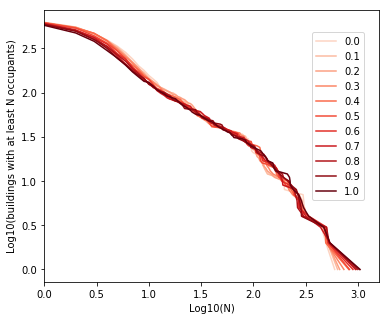

In [18]:
### plot the max occupancy of all buildings as a cdf

import matplotlib.colors as colors
import matplotlib.cm as cmx

minVal, maxVal = -2, 10.
cmOcc = plt.cm.get_cmap('Reds')
cNorm = colors.Normalize(vmin=minVal, vmax=maxVal)
scalarMap3 = cmx.ScalarMappable(norm=cNorm, cmap=cmOcc)
scalarMap3._A = []

fig = plt.figure()
fig.set_size_inches(6,5)
ax1 = fig.add_subplot(111)
lines = []
labels = [[] for j in range(11)]
for j in range(len(nonLinParams)):
    cl = scalarMap3.to_rgba((np.float(j)))
    cl = colors.rgb2hex(cl)
    occupantCounts = np.unique(buildingMaxOcc[:,j])
    print '%.1f'%nonLinParams[j], occupantCounts[-1], len(np.where(buildingMaxOcc[:,j]==0)[0])
    pOccupantCounts = np.zeros((len(occupantCounts)))
    for it,o in enumerate(occupantCounts):
        pOccupantCounts[it] = len(np.where(buildingMaxOcc[:,j]>=o)[0])
    l1, = ax1.plot(np.log10(occupantCounts), np.log10(pOccupantCounts), \
            color=cl) #/np.float(len(buildingMaxOcc[:,j]))
    lines.append(l1)
    labels[j]='%.1f'%(nonLinParams[j])
#     x1 = np.log10(occupantCounts[-1])
#     y1 = pOccupantCounts[-1]/np.float(len(buildingMaxOcc[:,j]))
#     y2 = pOccupantCounts[1]/np.float(len(buildingMaxOcc[:,j]))
#     ax1.plot([x1,x1],[y1,y2],color=cl,linewidth=0.9,linestyle='--')
#     ax1.plot([0,x1],[y2,y2],color=cl,linewidth=0.9,linestyle='--')
ax1.set_xlabel('Log10(N)')
ax1.set_ylabel('Log10(buildings with at least N occupants)')
ax1.set_xlim([0,3.2])
ax1.legend(lines,labels, loc=[0.8,0.3])
# fig.savefig('../Useful_Results/logBuildingCounts.png', dpi=300, format='png',  bbox_inches='tight')

In [3]:
cmRes, cmComm = plt.cm.get_cmap('Oranges'), plt.cm.get_cmap('Blues')
scalarMapRes, scalarMapComm = cmx.ScalarMappable(norm=cNorm, cmap=cmRes), \
                            cmx.ScalarMappable(norm=cNorm, cmap=cmComm)
scalarMapRes._A, scalarMapComm._A = [], []

colorMaps = [scalarMapRes, scalarMapComm]
testArray = [resMaxOcc, othMaxOcc]

fig = plt.figure()
fig.set_size_inches(12,5)
ax = [fig.add_subplot(121), fig.add_subplot(122)]
for axInd in range(2):
    lines = []
    labels = [[] for j in range(11)]
    for j in range(len(nonLinParams)):
        cl = colorMaps[axInd].to_rgba((np.float(j)))
        cl = colors.rgb2hex(cl)
        occupantCounts = np.unique(testArray[axInd][:,j])
        print '%.1f'%nonLinParams[j], occupantCounts[-1], len(np.where(testArray[axInd][:,j]==0)[0])
        pOccupantCounts = np.zeros((len(occupantCounts)))
        for it,o in enumerate(occupantCounts):
            pOccupantCounts[it] = len(np.where(testArray[axInd][:,j]>=o)[0])
        l1, = ax[axInd].plot(np.log10(occupantCounts), pOccupantCounts/np.float(len(testArray[axInd][:,j])), \
                color=cl)
        lines.append(l1)
        labels[j]='%.1f'%(nonLinParams[j])
        x1 = np.log10(occupantCounts[-1])
        y1 = pOccupantCounts[-1]/np.float(len(testArray[axInd][:,j]))
        y2 = pOccupantCounts[1]/np.float(len(testArray[axInd][:,j]))
        ax[axInd].plot([x1,x1],[y1,y2],color=cl,linewidth=0.9,linestyle='--')
        ax[axInd].plot([0,x1],[y2,y2],color=cl,linewidth=0.9,linestyle='--')
    ax[axInd].set_xlabel('Log10(N)')
    ax[axInd].set_ylabel('P(building has at least N occupants)')
    ax[axInd].set_xlim([0,3.2])
    ax[axInd].legend(lines,labels,ncol=2)
# fig.savefig('../Useful_Results/BuildingProbabilities.png', dpi=300, format='png',  bbox_inches='tight')

In [20]:
np.shape(buildingMaxOcc)

(661, 11)

0.0 598.0 39
0.1 637.0 47
0.2 667.0 41
0.3 732.0 50
0.4 816.0 48
0.5 828.0 47
0.6 893.0 58
0.7 945.0 59
0.8 980.0 69
0.9 1025.0 74
1.0 1045.0 85


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


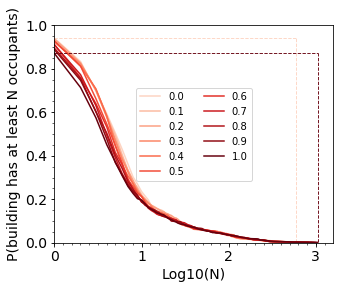

In [21]:
fig = plt.figure()
fig.set_size_inches(5,4)
ax = [fig.add_subplot(111)]
for axInd in range(1):
    lines = []
    labels = [[] for j in range(11)]
    for j in range(len(nonLinParams)):
        cl = scalarMap3.to_rgba((np.float(j)))
        cl = colors.rgb2hex(cl)
        occupantCounts = np.unique(buildingMaxOcc[:,j])
        print '%.1f'%nonLinParams[j], occupantCounts[-1], len(np.where(buildingMaxOcc[:,j]==0)[0])
        pOccupantCounts = np.zeros((len(occupantCounts)))
        for it,o in enumerate(occupantCounts):
            pOccupantCounts[it] = len(np.where(buildingMaxOcc[:,j]>=o)[0])
        l1, = ax[axInd].plot(np.log10(occupantCounts), pOccupantCounts/np.float(len(buildingMaxOcc[:,j])), \
                color=cl)
        lines.append(l1)
        labels[j]='%.1f'%(nonLinParams[j])
        x1 = np.log10(occupantCounts[-1])
        y1 = pOccupantCounts[-1]/np.float(len(buildingMaxOcc[:,j]))
        y2 = pOccupantCounts[1]/np.float(len(buildingMaxOcc[:,j]))
        if j in [0,10]:
            ax[axInd].plot([x1,x1],[y1,y2],color=cl,linewidth=0.9,linestyle='--')
            ax[axInd].plot([0,x1],[y2,y2],color=cl,linewidth=0.9,linestyle='--')
    ax[axInd].set_xlabel('Log10(N)',fontsize=14)
    ax[axInd].set_ylabel('P(building has at least N occupants)',fontsize=14)
    ax[axInd].set_xlim([0,3.2])
    ax[axInd].set_ylim([0,1])
    ax[axInd].set_xticks(np.arange(0,3.11,0.1), minor=True)
    ax[axInd].set_yticks(np.arange(0,1.01,0.05), minor=True)
    ax[axInd].legend(lines,labels,ncol=2)
    ax[axInd].tick_params(axis='both', labelsize=14)
# fig.savefig('../Useful_Results/BuildingProbabilities.png', dpi=300, format='png',  bbox_inches='tight')

In [2]:
## plot the occupancy distributions for res and commercial space
fig, ax = plt.subplots(2,11, sharex='col', sharey='row')
fig.set_size_inches(14,2.5)
axs = ax.ravel()
for j in range(len(nonLinParams)):
    resOcc, commOcc = [], []
    for bId in tractBuildings[t]:
        if tractBuildings[t][bId]['category']=='res':
            resOcc.append(np.max(tractBuildings[t][bId]['occupancy'][j,:]))
        if tractBuildings[t][bId]['category']=='wo':
            commOcc.append(np.max(tractBuildings[t][bId]['occupancy'][j,:]))       
    resBins = np.arange(0,42.1,2)
    resBins[-1] = 2000
    resHist, resEdges = np.histogram(resOcc, bins=resBins, density=False)
    axs[j].bar(resEdges[:-1]+1, resHist/np.float(sum(resHist)), width=2)
    axs[j].set_xlim([0,42])
    axs[j].set_ylim([0,0.5])
    
    commBins = np.arange(0,42.1,2)
    commBins[-1] = 2000
    commHist, commEdges = np.histogram(commOcc, bins=commBins, density=False)
    axs[11+j].bar(commEdges[:-1]+1, commHist/np.float(sum(commHist)), width=2, color='r')
    axs[11+j].set_xlim([0,42])
    axs[11+j].set_ylim([0,0.27])
    
# fig.tight_layout()

In [24]:
max_occupied_buiding, maxO = tractBuildings[t].keys()[0], 0.
for bId in tractBuildings[t].keys():
    if max(tractBuildings[t][bId]['occupancy'][0,:])>maxO:
        maxO = max(tractBuildings[t][bId]['occupancy'][0,:])
        max_occupied_buiding = bId

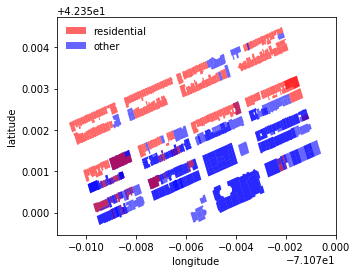

In [25]:
t = tracts[0]
fig = plt.figure()
axs = [fig.add_subplot(111)]
fig.set_size_inches(5,4)
j, a1 = 0, 0.6
for bId in tractBuildings[t]:
    geom = np.array( tractBuildings[t][bId]['geometry'] )
    axs[j].plot(geom[:,0], geom[:,1], color='k',linewidth=0.)
    ptchs = []
    poly = Polygon2(geom)
    ptchs.append(poly)
    if tractBuildings[t][bId]['category'] == 'res':
        axs[j].add_collection(PatchCollection(ptchs,facecolor='r', alpha=a1, edgecolor='none'))
    if tractBuildings[t][bId]['category'] == 'wo':
        axs[j].add_collection(PatchCollection(ptchs,facecolor='b', alpha=a1, edgecolor='none'))
        
r1 = plt.Rectangle((0, 0), 1, 1, fc='r', alpha=a1)
r2 = plt.Rectangle((0, 0), 1, 1, fc='b', alpha=a1)
axs[0].legend([r1,r2], ['residential', 'other'], loc=2, frameon=False)
axs[0].set_xticks(np.arange(-71.08, -71.07,0.002));
axs[0].set_yticks(np.arange(42.35,42.355,0.001));
axs[0].set_xlabel('longitude'), axs[0].set_ylabel('latitude');
# fig.savefig('../Useful_Results/BB1.png', dpi=300, format='png',  bbox_inches='tight')

In [1]:
t = tracts[0]
fig, ax = plt.subplots(2,2,sharex=True, sharey=True)
axs = ax.ravel()
fig.set_size_inches(9,7)
a1, a2 = 0.2, 1
testVals = [0,0.3,0.5,1]
for j,tVal in enumerate(testVals):
    jVal = np.where(np.round(nonLinParams,1)==tVal)[0][0]
    print j, tVal, jVal
    for bId in tractBuildings[t]:
        geom = np.array( tractBuildings[t][bId]['geometry'] )
        axs[j].plot(geom[:,0], geom[:,1], color='k',linewidth=0.)
        ptchs = []
        poly = Polygon2(geom)
        ptchs.append(poly)
        if tractBuildings[t][bId]['category'] == 'res':
            if max(tractBuildings[t][bId]['occupancy'][jVal,:]) == 0:
                axs[j].add_collection(PatchCollection(ptchs,facecolor='r', alpha=a2, edgecolor='none'))
            else:
                axs[j].add_collection(PatchCollection(ptchs,facecolor='k', alpha=a1, edgecolor='none'))
            
        if tractBuildings[t][bId]['category'] == 'wo':
            if max(tractBuildings[t][bId]['occupancy'][jVal,:]) == 0:
                axs[j].add_collection(PatchCollection(ptchs,facecolor='g', alpha=a2, edgecolor='none'))
            else:
                axs[j].add_collection(PatchCollection(ptchs,facecolor='k', alpha=a1, edgecolor='none'))
            
r1 = plt.Rectangle((0, 0), 1, 1, fc='r', alpha=a1)
# r2 = plt.Rectangle((0, 0), 1, 1, fc='b', alpha=a1)
r3 = plt.Rectangle((0, 0), 1, 1, fc='g', alpha=a1)
r4 = plt.Rectangle((0, 0), 1, 1, fc='k', alpha=a1)

for j in range(4):
    str111 = r'$\mu$ = %.1f'%testVals[j]
    axs[j].set_title(str111)
    axs[j].set_xticks(np.arange(-71.08, -71.07,0.002));
    axs[j].set_yticks(np.arange(42.35,42.355,0.001));
    axs[j].set_xlabel('longitude'), axs[j].set_ylabel('latitude');
axs[0].legend([r1,r3,r4], ['Unocc. Res', 'Unocc. Com', 'Occ.'], loc=2, frameon=False)
# fig.savefig('../Useful_Results/BB2.png', dpi=300, format='png',  bbox_inches='tight')

In [28]:
# ### calculating probs for paper example
# mu = 0.5
# testArray = ([100.,200.,500.])
# p1 = np.zeros(np.shape(testArray))
# p2 = np.zeros(np.shape(testArray))
# for j in range(3):
#     p1[j] = testArray[j]/sum(testArray)
#     denom2 = sum([(t/sum(testArray))**(1+mu) for t in testArray])
#     p2[j] = ((testArray[j]/sum(testArray))**(1+mu))/denom2
# t = np.round(p1, 3)
# print t
# t = np.round(p2, 3)
# print t

In [32]:
with open('../SkeletonFiles/header.txt', 'r') as f:
    header = f.read()
with open('../SkeletonFiles/footer.txt', 'r') as f:
    footer = f.read()
    
### add the api key into the script
footer = footer.replace("INSERT_YOUR_KEY","")
    
with open('../SkeletonFiles/polygon_header.txt', 'r') as f:
    polygon_header = f.read()
with open('../SkeletonFiles/polygon_footer.txt', 'r') as f:
    polygon_footer = f.read()  
with open('../SkeletonFiles/line.txt', 'r') as f:
    liner = f.read()

def get_polygon_line(latitude, longitude):
    return '{lat:'+str(latitude)+', lng:'+str(longitude)+'},\n'

In [33]:
# Google Map
outputHtml = header
# get building color and coordinate
### get distinct polygons
for bId in tractBuildings[t].keys():
    if '_0' in bId:
        ptchs = []
        longitudes = [x[0] for x in tractBuildings[t][bId]['geometry']]
        latitudes = [x[1] for x in tractBuildings[t][bId]['geometry']]
        outputHtml += polygon_header
        for pointIndex in range(len(latitudes)):
            outputHtml += get_polygon_line(latitudes[pointIndex], \
                                           longitudes[pointIndex])
        outputHtml = outputHtml[:-2]
        outputHtml += polygon_footer.replace("#FF0000",colors.rgb2hex('b'))

outputHtml += footer
with open('../Useful_Results/Example_buildings.html', 'w') as f:
    f.write(outputHtml)